In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.metrics import mean_absolute_error

#from statistics import mode
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [6]:
# Read the data
def load_data():
    train_data = pd.read_csv('train.csv', index_col='Id')
    test_data = pd.read_csv('test.csv', index_col='Id')
    # Merge the splits so we can process them together
    full_data = pd.concat([train_data, test_data])
    # Preprocessing
    full_data = clean(full_data)
    full_data = encode(full_data)
    full_data = impute(full_data)
    # Reform splits
    train_data = full_data.loc[train_data.index, :]
    test_data = full_data.loc[test_data.index, :]
    return train_data, test_data

In [7]:
#Data Cleaning
def clean(full_data):
    full_data["Exterior2nd"] = full_data["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    full_data["GarageYrBlt"] = full_data["GarageYrBlt"].where(full_data.GarageYrBlt <= 2010, full_data.YearBuilt)
    # Names beginning with numbers are awkward to work with
    full_data.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return full_data

In [8]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour",
                "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType",
                "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType",
                "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(full_data):
    # Nominal categories
    for name in features_nom:
        full_data[name] = full_data[name].astype("category")
        # Add a None category for missing values
        if "None" not in full_data[name].cat.categories:
            full_data[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        full_data[name] = full_data[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return full_data


In [9]:
def impute(full_data):
    for name in full_data.select_dtypes("number"):
        full_data[name] = full_data[name].fillna(0)
    for name in full_data.select_dtypes("category"):
        full_data[name] = full_data[name].fillna("None")
    return full_data


In [10]:
train_data, test_data = load_data()

In [11]:
# Peek at the values
display(train_data.describe())
display(test_data.describe())

# Display information about dtypes and missing values
display(train_data.info())
display(test_data.info())

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,57.623288,10516.828082,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,34.664304,9981.264932,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,42.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,63.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,79.000000,11601.500000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0
mean,57.910212,9819.161069,1971.357779,1983.662783,99.673749,438.902673,52.583276,553.915010,1045.400960,1156.534613,...,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705,0.0
std,32.266054,4955.517327,30.390071,21.130467,177.001792,455.257119,176.698671,437.351324,443.592976,398.165820,...,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740,0.0
min,0.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.0
25%,44.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.000000,784.000000,873.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.0
50%,63.000000,9399.000000,1973.000000,1992.000000,0.000000,350.000000,0.000000,460.000000,988.000000,1079.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.0
75%,78.000000,11517.500000,2001.000000,2004.000000,162.000000,752.000000,0.000000,797.500000,1304.000000,1382.500000,...,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,0.0
max,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,...,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotFrontage       1459 non-null   float64 
 3   LotArea           1459 non-null   int64   
 4   Street            1459 non-null   category
 5   Alley             1459 non-null   category
 6   LotShape          1459 non-null   category
 7   LandContour       1459 non-null   category
 8   Utilities         1459 non-null   category
 9   LotConfig         1459 non-null   category
 10  LandSlope         1459 non-null   category
 11  Neighborhood      1459 non-null   category
 12  Condition1        1459 non-null   category
 13  Condition2        1459 non-null   category
 14  BldgType          1459 non-null   category
 15  HouseStyle        1459 non-null   category
 16  OverallQual       145

None

In [12]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=cv, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


In [13]:
X = train_data.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14104 RMSLE


In [14]:
X = train_data.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

Top 20 MI:
OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
TotalBsmtSF     0.368536
GarageArea      0.361542
GarageCars      0.352312
BsmtQual        0.330803
KitchenQual     0.324679
ExterQual       0.324003
FirstFlrSF      0.282503
MSSubClass      0.281349
YearRemodAdd    0.274032
GarageYrBlt     0.272213
FullBath        0.263217
GarageFinish    0.262469
LotFrontage     0.218588
FireplaceQu     0.218161
GarageType      0.211553
Name: MI Scores, dtype: float64


Bootom 20 MI:
Heating             1.613066e-02
BsmtHalfBath        1.585608e-02
LotConfig           1.582819e-02
RoofStyle           1.376634e-02
BsmtFinSF2          1.271939e-02
BsmtFullBath        7.552324e-03
Functional          7.522779e-03
LowQualFinSF        7.084197e-03
RoofMatl            6.279666e-03
LandSlope           6.039953e-03
Threeseasonporch    3.520758e-03
Condition2          8.473363e-04
Street              6.097767e-04
Utilities   

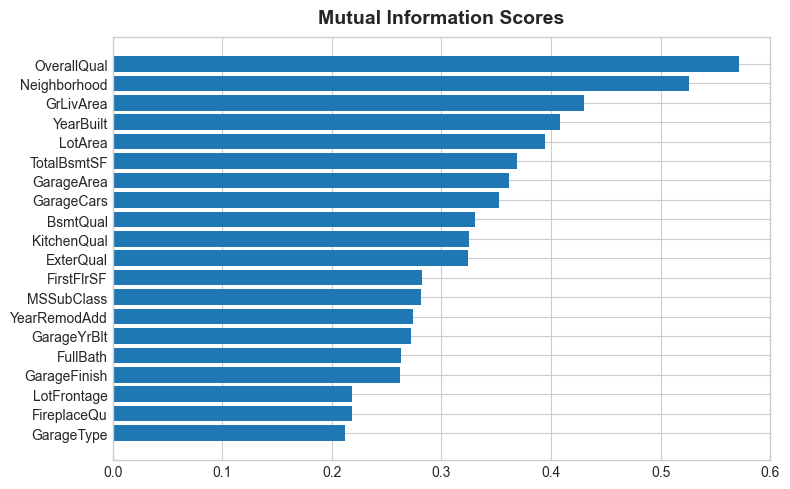

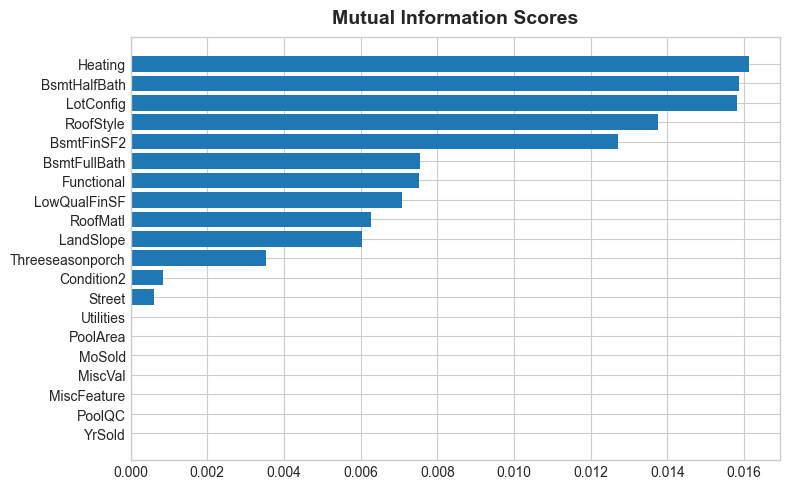

In [15]:
print("Top 20 MI:")
print(mi_scores.head(20))
print("\n")
print("Bootom 20 MI:")
print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [16]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [17]:
X = train_data.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.13940607038483321

In [18]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [19]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


#def break_down(df):
#    X = pd.DataFrame()
#    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
#    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X


Here are some ideas for other transforms you could explore:

Interactions between the quality Qual and condition Cond features. OverallQual, for instance, was a high-scoring feature. You could try combining it with OverallCond by converting both to integer type and taking a product.
Square roots of area features. This would convert units of square feet to just feet.
Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
Interactions between numeric and categorical features that describe the same thing. You could look at interactions between BsmtQual and TotalBsmtSF, for instance.
Other group statistics in Neighboorhood. We did the median of GrLivArea. Looking at mean, std, or count could be interesting. You could also try combining the group statistics with other features. Maybe the difference of GrLivArea and the median is important?

In [20]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [21]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [22]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

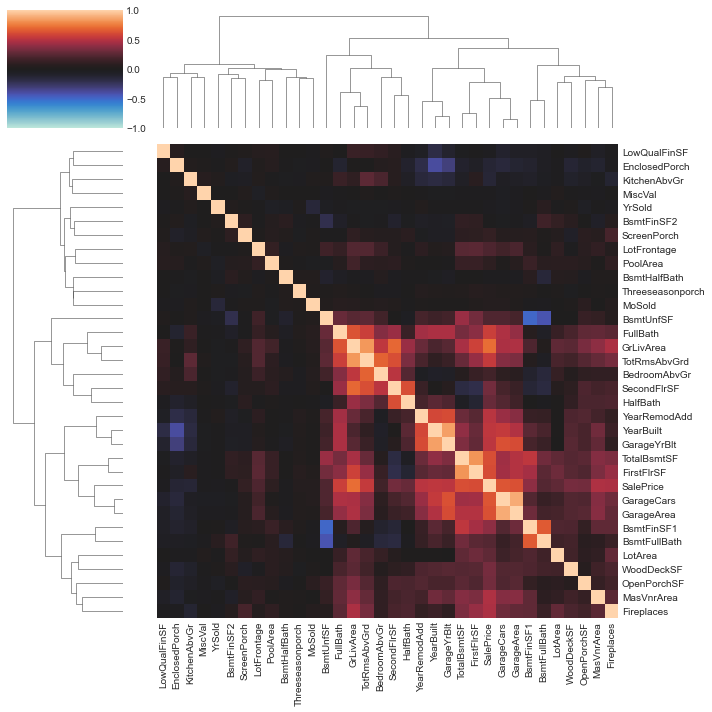

In [23]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(train_data, annot=None)

In [24]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

In [25]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


In [26]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder CatBoostEncoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    #encoder = CrossFoldEncoder(CatBoostEncoder, a=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


train_data, test_data = load_data()
X_train = create_features(train_data)
y_train = train_data.loc[:, "SalePrice"]

score_dataset(X_train, y_train)
#0.1381925629969659

0.13529351183349062

In [27]:
X_train = create_features(train_data)
y_train = train_data.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)
#0.12414985267470383

0.12322777683206862

Use it like:

encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
You can turn any of the encoders from the category_encoders library into a cross-fold encoder. The CatBoostEncoder would be worth trying. It's similar to MEstimateEncoder but uses some tricks to better prevent overfitting. Its smoothing parameter is called a instead of m.

Create Final Feature Set
Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [ ]:
# make sure to comment this out, before submitting 
"""
import optuna

def objective(trial):
       
    X_train = create_features(train_data)
    y_train = train_data.loc[:, "SalePrice"]
    
    xgb_params_2 = dict(
        random_state=trial.suggest_int("random_state", 0, 3), 
        num_parallel_tree=trial.suggest_int("num_parallel_tree", 1, 3), 
        max_depth=trial.suggest_int("max_depth", 1, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        
    )
    xgb_2 = XGBRegressor(**xgb_params_2) #XGBRegressor
    return score_dataset(X_train, y_train, xgb_2)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)
#xgb_params_2 = study.best_params

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
#Accuracy: 0.11600026478351594
#Best hyperparameters: {'random_state': 2, 'num_parallel_tree': 1, 'max_depth': 4, 
#                       'learning_rate': 0.003519434617186593, 'n_estimators': 7830, 
#                       'min_child_weight': 2, 'colsample_bytree': 0.9892180785433881, 
#                       'subsample': 0.3782508236463379, 'reg_alpha': 0.00022374959041048762, 
#                       'reg_lambda': 0.00010238969999451745}
"""

In [ ]:
X_train = create_features(train_data)
y_train = train_data.loc[:, "SalePrice"]

xgb_params_2 = dict(
    random_state=2, 
    num_parallel_tree=1, 
    max_depth=4,
    learning_rate=0.003519434617186593, 
    n_estimators=7830, 
    min_child_weight=2, 
    colsample_bytree=0.9892180785433881, 
    subsample=0.3782508236463379, 
    reg_alpha=0.00022374959041048762, 
    reg_lambda=0.00010238969999451745
)

xgb_2 = XGBRegressor(**xgb_params_2)
score_dataset(X_train, y_train, xgb_2)
#0.11600026478351594

In [ ]:
X_train, X_test = create_features(train_data, test_data)
y_train = train_data.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params_2)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
"""
from sklearn.model_selection import train_test_split

X_train = create_features(train_data)
y_train = train_data.loc[:, "SalePrice"]

X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train, test_size=0.1)

dt = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=1234)

#for colname in X_train.select_dtypes(["category"]):
#        X_train[colname] = X_train[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
log_y = np.log(y_train)
score = cross_val_score(dt, X_train, log_y, cv=5, scoring="neg_mean_squared_error")
score = -1 * score.mean()
score = np.sqrt(score)
print(score)